In [20]:
%matplotlib inline

# Basic
import io
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices

# SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# NLTK
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [21]:
data = pd.read_csv("training-data/spamcollectiondata.tsv", sep='\t', names = ["Category", "Message"])

In [22]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


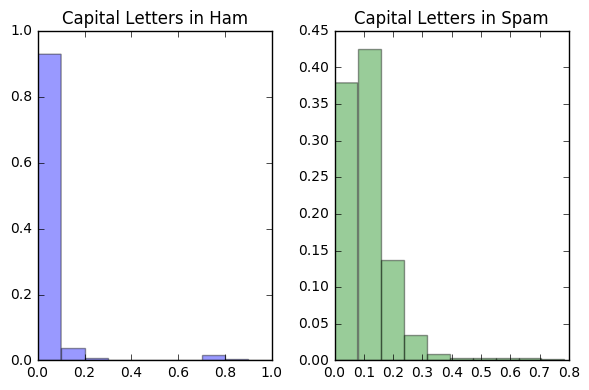

In [23]:
ham_caps = []
spam_caps = []

for index,row in data.iterrows():
    if row.Category == 'ham':
        ham_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))
    else:
        spam_caps.append(sum(1.0 for c in row.Message if c.isupper())/sum(1.0 for c in row.Message))


fig,axes = plt.subplots(nrows=1,ncols=2)
ax0, ax1 = axes.flatten()

ax0.set_title('Capital Letters in Ham')
ax0.hist(ham_caps,color='b',alpha=0.4,weights = np.ones_like(ham_caps)/len(ham_caps))

ax1.set_title('Capital Letters in Spam')
ax1.hist(spam_caps,color='g',alpha=0.4,weights = np.ones_like(spam_caps)/len(spam_caps))

fig.tight_layout()


In [24]:
message_data = [word.lower() for word in data['Message']]
category = data['Category'].tolist()
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
training_set = []
i = 0
for message in message_data:
    sentence = message.split(" ")
    filtered = []
    pr = []
    for word in sentence:
        if word.lower() not in stop:
            stemmed = stemmer.stem(word)
            filtered.append(stemmed)
    pr.append(filtered)
    pr.append(category[i])
    training_set.append(pr)
    i = i+1
    
train_df = pd.DataFrame(training_set)
train_df.columns = ['Lists','Labels']
train_df.head()
y = np.array(train_df.Labels)

for i in range(len(y)):
    if y[i] == 'ham':
        y[i] = 1
    else:
        y[i] = 0
        
y = np.ravel(y)

In [25]:
def list_to_dict(words_list):
  return dict([(word, True) for word in words_list])
 
training_set_formatted = [(list_to_dict(element[0]), element[1]) for element in training_set]

def generate_words_vector(training_set):
    words_vector = [] 
    for review in training_set:
        for word in review[0]:
            if word not in words_vector: words_vector.append(word) 
    return words_vector

def generate_X_matrix(training_set, words_vector):
    no_reviews = len(training_set)
    no_words = len(words_vector)
    X = np.zeros(shape=(no_reviews, no_words+1))
    for ii in range(0,no_reviews):
        X[ii][0] = 1
        review_text = training_set[ii][0]
        total_words_in_review = len(review_text)
        rt = list(review_text)
        for word in rt:
            word_occurences = rt.count(word)
            word_index = words_vector.index(word)+1
            X[ii][word_index] = word_occurences / float(total_words_in_review)
    return X

words_vector = generate_words_vector(training_set_formatted)
X = np.array(generate_X_matrix(training_set_formatted, words_vector))

In [8]:
# What percentage is ham?
print(y.mean())

0.8659368269921034


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, train_df.Labels, test_size=0.5, random_state=1)
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
probs = model.predict_proba(X_test)

predicted = model.predict(X_test)

act = 1 - y[:len(predicted)]
pred = []

for result in predicted:
    if result == 'spam':
        pred.append(1)
    else:
        pred.append(0)
        
# 1 is spam, 0 is ham
compare = pd.DataFrame({'Actual':act,'Predicted':pred,
                       'Prob is Ham':probs[:,0],
                       'Prob is Spam':probs[:,1]})

print(compare[compare['Prob is Spam']>=0.5].head(),'\n')
print(compare.head())

compare.to_csv('log_reg_output.csv',sep=',')

     Actual  Predicted  Prob is Ham  Prob is Spam
2434      0          1     0.464386      0.535614 

  Actual  Predicted  Prob is Ham  Prob is Spam
0      0          0     0.865463      0.134537
1      0          0     0.898919      0.101081
2      1          0     0.860582      0.139418
3      0          0     0.859309      0.140691
4      0          0     0.876628      0.123372


In [13]:
print(pd.DataFrame(y_test).describe())

       Labels
count    1672
unique      2
top       ham
freq     1451


In [14]:
# Comparing Ratio of Spam/Ham to Model's Ratio of 
print(1451.0/1672,1669.0/1672)

0.867822966507177 0.9982057416267942


In [26]:
print(words_vector)

['got', 'world', 'crazy..', 'go', 'great', 'cine', 'n', 'bugi', 'wat...', 'point,', 'e', 'amor', 'avail', 'buffet...', 'jurong', 'la', 'oni...', 'lar...', 'u', 'joke', 'ok', 'wif', 'comp', '21st', 'wkli', '2005.', 'receiv', 'entri', 'txt', 'rate)t&c', 'cup', 'fa', 'tkts', '2', 'final', '08452810075over18', 'text', 'free', 'appli', 'question(std', '87121', 'may', 'win', 'alreadi', 'say...', 'c', 'earli', 'hor...', 'dun', 'say', 'though', 'usf,', 'goe', 'live', 'nah', 'think', 'around', "don't", 'chgs', 'still?', 'send,', 'it', '3', 'fun', 'xxx', 'darl', 'word', 'rcv', 'like', "i'd", 'week', 'ok!', 'freemsg', 'std', 'hey', 'tb', 'back!', '£1.50', 'brother', 'speak', 'aid', 'treat', 'me.', 'patent.', 'even', 'request', 'press', 'per', 'nurungu', 'set', 'callers.', 'mell', 'minnaminungint', '(oru', 'copi', 'friend', 'callertun', 'vettam)', '*9', 'network', 'valid', 'valu', 'prize', 'claim', 'receivea', '12', 'kl341.', 'call', 'only.', 'hour', 'code', 'reward!', '09061701461.', '£900', 'win

In [25]:
arr = np.zeros(12236)
test_phrase = 'Hello world! This is spam.'

##########################


test_phrase = test_phrase.lower()

for ii in range(len(X[0])):
    review_text = training_set[ii][0]
    total_words_in_review = len(review_text)
    rt = list(review_text)
print(test_phrase)





###########################
'''
no_reviews = len(training_set)
    no_words = len(words_vector)
    X = np.zeros(12236)
    for ii in range(12236):
        X[ii] = 1
        review_text = training_set[ii][0]
        total_words_in_review = len(review_text)
        rt = list(review_text)
        for word in rt:
            word_occurences = rt.count(word)
            word_index = words_vector.index(word)+1
            X[ii][word_index] = word_occurences / float(total_words_in_review)
'''           

IndexError: list index out of range

In [19]:
print(words_vector)

['got', 'world', 'crazy..', 'go', 'great', 'cine', 'n', 'bugi', 'wat...', 'point,', 'e', 'amor', 'avail', 'buffet...', 'jurong', 'la', 'oni...', 'lar...', 'u', 'joke', 'ok', 'wif', 'comp', '21st', 'wkli', '2005.', 'receiv', 'entri', 'txt', 'rate)t&c', 'cup', 'fa', 'tkts', '2', 'final', '08452810075over18', 'text', 'free', 'appli', 'question(std', '87121', 'may', 'win', 'alreadi', 'say...', 'c', 'earli', 'hor...', 'dun', 'say', 'though', 'usf,', 'goe', 'live', 'nah', 'think', 'around', "don't", 'chgs', 'still?', 'send,', 'it', '3', 'fun', 'xxx', 'darl', 'word', 'rcv', 'like', "i'd", 'week', 'ok!', 'freemsg', 'std', 'hey', 'tb', 'back!', '£1.50', 'brother', 'speak', 'aid', 'treat', 'me.', 'patent.', 'even', 'request', 'press', 'per', 'nurungu', 'set', 'callers.', 'mell', 'minnaminungint', '(oru', 'copi', 'friend', 'callertun', 'vettam)', '*9', 'network', 'valid', 'valu', 'prize', 'claim', 'receivea', '12', 'kl341.', 'call', 'only.', 'hour', 'code', 'reward!', '09061701461.', '£900', 'win

In [29]:
pct = model.predict_proba(arr.reshape(1,-1))[0][1]*100
print("{}% chance of Spam.".format(round(pct,3)))

29.334% chance of Spam.
